## **NYC Taxi Tip Prediction**

##### **Libraries loading and utils**

In [228]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.inspection import permutation_importance
from meteostat import Point as Pt
from meteostat import Daily
import geopandas as gpd
from shapely.geometry import Point
import shap

#### **Utils**

In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
     R = 6371 # Earth radius in kilometers

     phi1, phi2 = np.radians(lat1), np.radians(lat2)
     dphi = np.radians(lat2 - lat1)
     dlambda = np.radians(lon2 - lon1)
     a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
     
     return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

##### **Load the Dataset**

In [4]:
#### Structure of the data set
train_data = pd.read_parquet(path = "Data/train_1.parquet")
test_data = pd.read_parquet(path = "Data/test_1.parquet")


In [5]:
train_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
0,1,2024-01-15 20:37:28,2024-01-15 20:56:43,1.0,3.30,1.0,N,1,19.1,3.5,0.5,4.80,0.0,1.0,2.5,0.0,40.734576,-74.002875,40.768615,-73.965635
1,2,2024-01-25 19:41:24,2024-01-25 19:44:42,1.0,0.72,1.0,N,1,5.8,2.5,0.5,2.46,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.780436,-73.957012
2,2,2024-01-25 15:48:48,2024-01-25 16:24:23,2.0,7.45,1.0,N,1,38.7,0.0,0.5,3.00,0.0,1.0,2.5,0.0,40.717773,-74.007880,40.780436,-73.957012
3,2,2024-01-27 00:47:26,2024-01-27 00:55:55,1.0,1.53,1.0,N,1,10.0,1.0,0.5,2.25,0.0,1.0,2.5,0.0,40.720889,-73.996919,40.747746,-73.978492
4,2,2024-01-28 13:14:26,2024-01-28 13:22:34,1.0,1.53,1.0,N,1,10.0,0.0,0.5,3.50,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.747746,-73.978492


In [6]:
train_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon'],
      dtype='object')

##### **Feature Enginneering Pipeline**

Feature Enginneering is a very imporant task in this type of problems

#### **Time features**

In [7]:
## Time feature Engineering Pipline

def add_time_features(df):
     # Convert datetime columns
     df["pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
     df["dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

     # Duration in minutes
     df["duration"] = (df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds() / 60
     
     # Date-based features
     df["pickup_hour"] = df["pickup_datetime"].dt.hour
     df["pickup_day"] = df["pickup_datetime"].dt.day
     df["pickup_weekday"] = df["pickup_datetime"].dt.weekday
     df["is_night"] = (df["pickup_datetime"].dt.hour >= 0) & (df["pickup_datetime"].dt.hour < 7)
     df["is_weekend"] = df["pickup_datetime"].dt.weekday >= 5

     df = df.drop(columns=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
     return df

##### **Spatial Features**

In [8]:
def add_distance_features(df):
     df["trip_distance"] = haversine_distance(df["PU_location_lat"], df["PU_location_lon"], 
                                              df["DO_location_lat"], df["DO_location_lon"])
     return df

* **Add Airport Proximity Features** : Include features to indicate whether a pickup of drop-off is close to one of NYC's main airports (JFK, LaGuardia, Newark). These proximity indicators can be binary features based on latitude and longitude comparaisons, as shown below

In [9]:
def airport_proximity(df):
    # JFK
    
    Is_JFK = ((df['PU_location_lat'].between(40.63, 40.65)) & 
                    (df['PU_location_lon'].between(-73.79, -73.77))) | \
                   ((df['DO_location_lat'].between(40.63, 40.65)) & 
                    (df['DO_location_lon'].between(-73.79, -73.77)))
    
    # LaGuardia
    
    Is_laguardia = ((df['PU_location_lat'].between(40.77, 40.78)) & 
                          (df['PU_location_lon'].between(-73.88, -73.87))) | \
                         ((df['DO_location_lat'].between(40.77, 40.78)) & 
                          (df['DO_location_lon'].between(-73.88, -73.87)))
    
    # Newark
    
    Is_newark = ((df['PU_location_lat'].between(40.68, 40.69)) & 
                       (df['PU_location_lon'].between(-74.18, -74.17))) | \
                      ((df['DO_location_lat'].between(40.68, 40.69)) & 
                       (df['DO_location_lon'].between(-74.18, -74.17)))
    
    df["Is_Airport"] = Is_JFK | Is_laguardia | Is_newark
    return df

* **Distance to Key Landmarks** : The idea is to calculate the distance from each pickup and drop-off location to major NYC landmarks, such as Times Square, Central Park, ... This could help capture tourism or business-related trips, which might correlate with different tipping behaviors.

In [59]:
def distance_to_Key_Landmarks(df):

    ## A dictionnary containing the most iconic landmarks in New York City

    nyc_landmarks = {
    "Liberty": [40.6892, -74.0445],
    "Empire": [40.748817, -73.985428],
    "CentralPark": [40.785091, -73.968285],
    "TimesSquare": [40.758896, -73.985130],
    "BrooklynBridge": [40.706086, -73.996864],
    "OneWorld": [40.712743, -74.013379],
    "Rockefeller": [40.758740, -73.978674],
    "Broadway": [40.759011, -73.984472],
    "MetMuseum": [40.779437, -73.963244],
    "FifthAve": [40.774210, -73.965310],
    "GrandCentral": [40.752726, -73.977229],
    "HighLine": [40.747993, -74.004765],
    "WallStreet": [40.707491, -74.011276],
    "Chrysler": [40.751652, -73.975311],
    "StatenFerry": [40.701301, -74.013120]
    }

    ## Compute the haversine distances between Pickup and Dropoff locations
    min_distances = np.full(len(df), np.inf)
    for coords in nyc_landmarks.values():
        landmark_lat, landmark_lon = coords
        distances = haversine_distance(df['PU_location_lat'], df['PU_location_lon'], landmark_lat, landmark_lon)
    
        # Update min_distances with the minimum distance found for each landmark
        min_distances = np.minimum(min_distances, distances)

    # Assign the computed minimum distances back to the DataFrame

    df["distance_to_Key_Landmark"] = min_distances
    return(df)

* **Borough Clustering** : The idea here is to use the official Taxi and Limousine Comission (TLC) zones. And map each pickup and drop-off location to its corresponding zone and borough (Manhattan, Brooklyn, ...). Each zone has a unique ID.

In [11]:
def add_neighborhood(df):
    gdf = gpd.read_file("Data/NYC Taxi Zones.geojson")
    df["geometry"] = [Point(xy) for xy in zip(df["PU_location_lon"], df["PU_location_lat"])]
    df = gpd.GeoDataFrame(df, geometry="geometry"); df.crs = "EPSG:4326"
    df = gpd.sjoin(df, gdf, how = "left", predicate = "within")
    df = df.drop(columns = ["geometry", "index_right", "shape_area", "objectid", "shape_area", "objectid", "shape_leng", "location_id"])
    return df

##### **Creating the feature enginnering pipeline**

In [145]:
def filter_data(df):
     # Filter data by payment type (keep credit card payments only)
     df = df[df["payment_type"] == 1]

     return(df)

def Drop_useless(df, col_list = ["payment_type", "pickup_datetime", "dropoff_datetime", "zone"]):
     return df.drop(columns = col_list)

def Categorical_data(df, type = None):
     cat_data = ['VendorID',  'payment_type', 'RatecodeID', 'store_and_fwd_flag', 'borough']
     if (type == 'String'):
          for var in cat_data:
               df[var] = df[var].astype('category').astype(str).fillna('missing')
          return df      
     elif (type == 'Int'):
          for var in cat_data:
               df[var] = df[var].astype('category').cat.codes.astype('int32')
          return df
     return pd.get_dummies(df, columns = cat_data, drop_first = True)

# Pipeline for feature engineering 

base_pipeline = Pipeline([
     ('copy', FunctionTransformer(lambda df : df.copy())),   ## Avoid applying changes on the dataset passed in argument
     #('filter_data', FunctionTransformer(filter_data)),
     # Time features
     ("add_time_features", FunctionTransformer(add_time_features)),

     # Spatial features
     ("add_distance_features", FunctionTransformer(add_distance_features)),
     ("airport_proximity", FunctionTransformer(airport_proximity)),
     ("distance_to_Key_Landmarks", FunctionTransformer(distance_to_Key_Landmarks)),
     ("add_neighborhood", FunctionTransformer(add_neighborhood))
])

In [130]:
import copy
pipeline = copy.deepcopy(base_pipeline)
pipeline.steps.extend([('Categorical_data', FunctionTransformer(Categorical_data)),
                          ('Drop_useless', FunctionTransformer(lambda df: Drop_useless(df, ['pickup_datetime', 'dropoff_datetime', 'zone'])))])
train_data_fe = pipeline.fit_transform(train_data)

In [127]:
test_data_fe = pipeline.transform(test_data)

In [131]:
train_data_fe.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'congestion_surcharge', 'Airport_fee', 'PU_location_lat',
       'PU_location_lon', 'DO_location_lat', 'DO_location_lon',
       'distance_to_Key_Landmark', 'duration', 'pickup_hour', 'pickup_day',
       'pickup_weekday', 'is_night', 'is_weekend', 'Is_Airport', 'VendorID_2',
       'payment_type_2', 'payment_type_3', 'payment_type_4', 'RatecodeID_2.0',
       'RatecodeID_3.0', 'RatecodeID_4.0', 'RatecodeID_5.0', 'RatecodeID_99.0',
       'store_and_fwd_flag_Y', 'borough_Brooklyn', 'borough_EWR',
       'borough_Manhattan', 'borough_Queens', 'borough_Staten Island'],
      dtype='object')

#### **Modèle linéaire simple**

Linear Regression - RMSE: 0.41378993353241517 r2: 0.7056567683254344


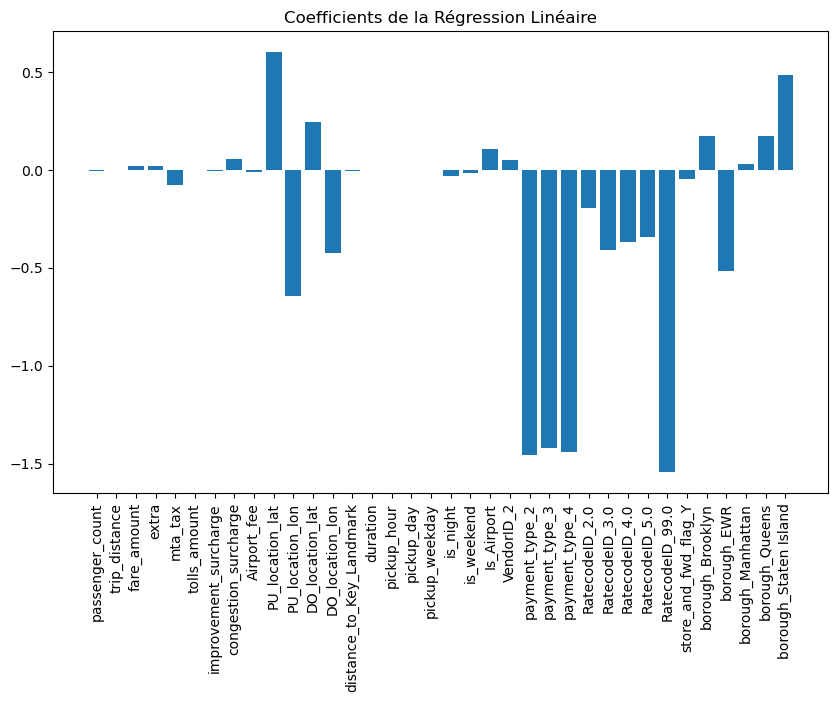

In [277]:
# Diviser les données en caractéristiques (X) et cible (y)

X = train_data_fe.drop("tip_amount", axis = 1)
y = np.log1p(train_data_fe["tip_amount"])

# Diviser le jeu de données en entraînement et de test

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X, y, test_size = 0.2, random_state = 42)

# 1. Régression Simple

lin_reg = LinearRegression()
lin_reg.fit(X_train_s, y_train_s)
y_pred_s = lin_reg.predict(X_val_s)

# Évaluation de la régression linéaire

rmse_lin = np.sqrt(mean_squared_error(y_val_s, y_pred_s))
r2_lin = r2_score(y_val_s, y_pred_s)
print("Linear Regression - RMSE:", rmse_lin, "r2:", r2_lin)

## Visualisation des coefficients

plt.figure(figsize=(10,6))
plt.bar(X.columns, lin_reg.coef_)
plt.xticks(rotation = 90)
plt.title("Coefficients de la Régression Linéaire")
plt.show()

In [276]:
r2_score(np.exp(y_val_s)-1, np.exp(y_pred_s)-1)

0.6088629327086155

#### **Encore des choses simples**

Fitting 5 folds for each of 65 candidates, totalling 325 fits
Meilleurs paramètres pour ElasticNet : {'alpha': 0.001, 'l1_ratio': 0.1}
Meilleure RMSE pour ElasticNet : 0.7033060932290282


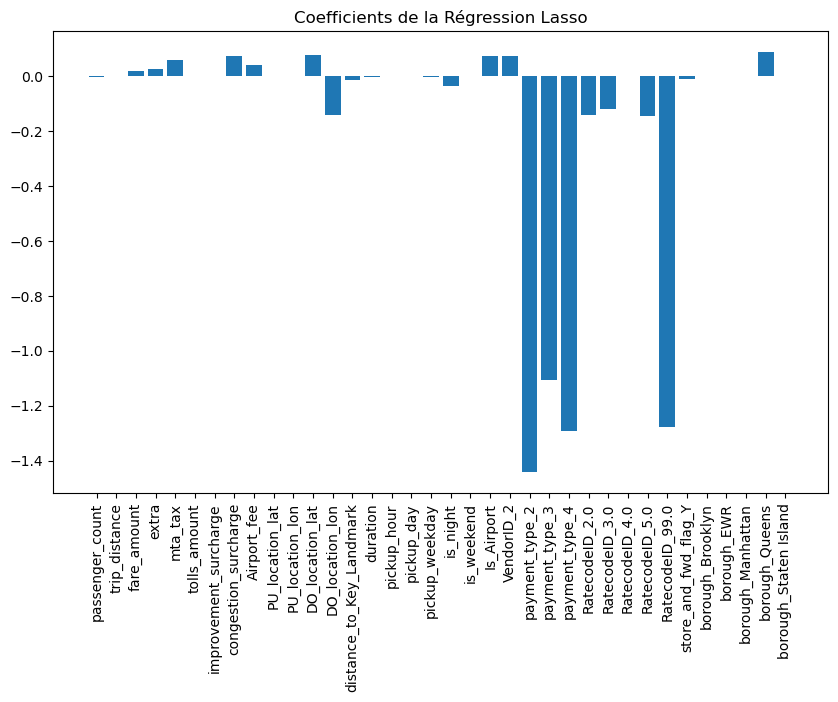

In [199]:
# Elastic Net
elastic_net = ElasticNet()


## Définir les paramètres pour le modèle ElasticNet
elasticnet_params = {
    'alpha': np.logspace(-3, 3, 13),  # Valeurs de alpha allant de 0.001 à 1000
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]  # Ratio entre L1 et L2
}

# Initialiser le GridSearch pour ElasticNet
elasticnet_grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=elasticnet_params,
    scoring='r2',
    cv=5,  # Validation croisée à 5 K-Folds
    verbose=1,
    n_jobs=-1
)

# Ajuster le modèle ElasticNet avec GridSearch
elasticnet_grid_search.fit(X, y)
print("Meilleurs paramètres pour ElasticNet :", elasticnet_grid_search.best_params_)
print("Meilleure RMSE pour ElasticNet :", elasticnet_grid_search.best_score_)

plt.figure(figsize=(10,6))
plt.bar(X.columns, elasticnet_grid_search.best_estimator_.coef_)
plt.xticks(rotation = 90)
plt.title("Coefficients de la Régression Lasso")
plt.show()


#### **Random Forest Pipeline**

In [138]:
import copy

rf_pipeline = copy.deepcopy(base_pipeline)
rf_pipeline.steps.extend([('Categorical_data', FunctionTransformer(Categorical_data)),
                          ('Drop_useless', FunctionTransformer(lambda df: Drop_useless(df, ['pickup_datetime', 'dropoff_datetime', 'zone'])))])
train_data_rf = rf_pipeline.fit_transform(train_data)

In [143]:
train_data_rf.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'congestion_surcharge', 'Airport_fee', 'PU_location_lat',
       'PU_location_lon', 'DO_location_lat', 'DO_location_lon',
       'distance_to_Key_Landmark', 'duration', 'pickup_hour', 'pickup_day',
       'pickup_weekday', 'is_night', 'is_weekend', 'Is_Airport', 'VendorID_2',
       'payment_type_2', 'payment_type_3', 'payment_type_4', 'RatecodeID_2.0',
       'RatecodeID_3.0', 'RatecodeID_4.0', 'RatecodeID_5.0', 'RatecodeID_99.0',
       'store_and_fwd_flag_Y', 'borough_Brooklyn', 'borough_EWR',
       'borough_Manhattan', 'borough_Queens', 'borough_Staten Island'],
      dtype='object')

In [141]:
test_data_rf = rf_pipeline.fit_transform(test_data)

In [142]:
test_data_rf.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'duration', 'pickup_hour', 'pickup_day',
       'pickup_weekday', 'is_night', 'is_weekend', 'Is_Airport',
       'distance_to_Key_Landmark', 'VendorID_2', 'payment_type_2',
       'payment_type_3', 'payment_type_4', 'RatecodeID_2.0', 'RatecodeID_3.0',
       'RatecodeID_4.0', 'RatecodeID_5.0', 'RatecodeID_6.0', 'RatecodeID_99.0',
       'store_and_fwd_flag_Y', 'borough_Brooklyn', 'borough_EWR',
       'borough_Manhattan', 'borough_Queens', 'borough_Staten Island'],
      dtype='object')

In [139]:
X_rf = train_data_rf.drop(columns = ["tip_amount"])
y_rf = train_data_rf["tip_amount"]
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state = 42)

In [140]:
X_rf.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'distance_to_Key_Landmark', 'duration',
       'pickup_hour', 'pickup_day', 'pickup_weekday', 'is_night', 'is_weekend',
       'Is_Airport', 'VendorID_2', 'payment_type_2', 'payment_type_3',
       'payment_type_4', 'RatecodeID_2.0', 'RatecodeID_3.0', 'RatecodeID_4.0',
       'RatecodeID_5.0', 'RatecodeID_99.0', 'store_and_fwd_flag_Y',
       'borough_Brooklyn', 'borough_EWR', 'borough_Manhattan',
       'borough_Queens', 'borough_Staten Island'],
      dtype='object')

In [278]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Définition de l'espace des hyperparamètres pour la Randomized Search
param_distributions = {
    'n_estimators': np.arange(100, 1000, 50),
    'max_depth': [5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Modèle de base
rf = RandomForestRegressor(random_state=42)

# Randomized Search avec RandomForest et validation croisée 5-Fold
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,  # Nombre d'itérations aléatoires
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Entraînement de la Randomized Search pour trouver les meilleurs hyperparamètres
random_search.fit(X_rf, y_rf)
best_rf = random_search.best_estimator_  # Meilleur modèle

print("Meilleurs paramètres :", random_search.best_params_)

Meilleurs paramètres : {'n_estimators': 950, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}


In [293]:
dump(best_rf, "Data/RandomForest_Tunned_2_V2")

['Data/RandomForest_Tunned_2_V2']

In [ ]:
# Génération de la courbe d'apprentissage avec les meilleurs paramètres trouvés
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_rf, y_rf, cv=5, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calcul des RMSE pour les ensembles d'entraînement et de validation
train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

# Calcul des scores R² pour les ensembles d'entraînement et de validation
train_sizes_r2, train_scores_r2, val_scores_r2 = learning_curve(
    best_rf, X_rf, y_rf, cv=5, scoring="r2", train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_r2 = train_scores_r2.mean(axis=1)
val_r2 = val_scores_r2.mean(axis=1)

# Tracé de la courbe d'apprentissage pour RMSE et R²
plt.figure(figsize=(14, 6))

# Courbe d'apprentissage - RMSE
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_rmse, 'o-', color='blue', label="Entraînement")
plt.plot(train_sizes, val_rmse, 'o-', color='green', label="Validation")
plt.title("Courbe d'apprentissage - RMSE (Random Forest)")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("RMSE")
plt.legend()

# Courbe d'apprentissage - R²
plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_r2, 'o-', color='blue', label="Entraînement")
plt.plot(train_sizes, val_r2, 'o-', color='green', label="Validation")
plt.title("Courbe d'apprentissage - Score R² (Random Forest)")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("R²")
plt.legend()

plt.tight_layout()
plt.show()

Meilleurs paramètres : {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}


In [16]:
# Train the model with the selected parameters

rf_model = RandomForestRegressor(n_estimators = 300,
                                warm_start = True, # Train with a high number of trees
                                max_depth=10,
                                min_samples_leaf = 4,
                                min_samples_split= 10,
                                bootstrap = True, 
                                random_state = 42)

## Etudier l'erreur de generalisation (Early stopping)

## Early stopping parameters

n_trees_step = 10 # Add trees in increments
best_score = float('inf')
early_stop_rounds = 5
no_improvement_count = 0
best_n_trees = 0 

val_scores = []
train_scores = []

# Progressively train the model with more trees, checking validation score each step
for n_trees in range(n_trees_step, rf_model.n_estimators + 1, n_trees_step):
    rf_model.set_params(n_estimators=n_trees)
    rf_model.fit(X_train_rf, y_train_rf)
    
    # Compute training and validation MSE
    y_pred_val = rf_model.predict(X_val_rf)
    val_r2 = r2_score(y_val_rf, y_pred_val)
    train_r2 = r2_score(y_train_rf, rf_model.predict(X_train_rf))
    
    val_scores.append(val_r2)
    train_scores.append(train_r2)
    
    # Early stopping check
    if val_r2 < best_score:
        best_score = val_r2
        best_n_trees = n_trees
        no_improvement_count = 0
    else:
        no_improvement_count += 1
    
    if no_improvement_count >= early_stop_rounds:
        print(f"Early stopping at {best_n_trees} trees with validation r2: {best_score}")
        break

Early stopping at 10 trees with validation r2: 0.6139439633601178


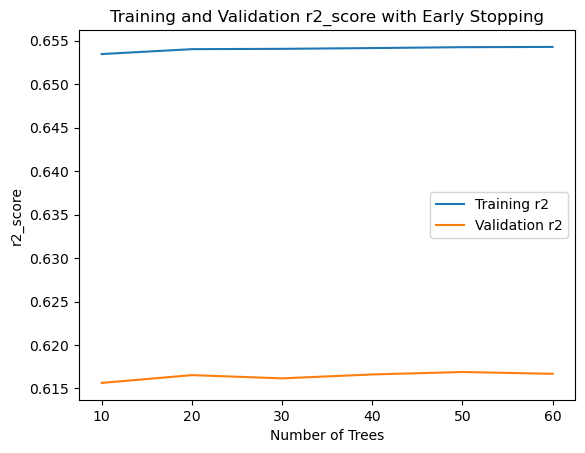

In [48]:
# Plot training and validation scores
plt.plot(range(n_trees_step, best_n_trees + n_trees_step*no_improvement_count + 1, n_trees_step), train_scores[:len(val_scores)], label='Training r2')
plt.plot(range(n_trees_step, best_n_trees + n_trees_step*no_improvement_count + 1, n_trees_step), val_scores, label='Validation r2')
plt.xlabel("Number of Trees")
plt.ylabel("r2_score")
plt.legend()
plt.title("Training and Validation r2_score with Early Stopping")
plt.show()

In [20]:
y_pred_rf_train = rf_model.predict(X_train_rf)
y_pred_rf_val = rf_model.predict(X_val_rf)
print('r2 score :', r2_score(y_val_rf, y_pred_rf_val))

r2 score : 0.6169877694175894


#### **XGBoost Pipeline**

* `Fitting 5 folds for each of 2268 candidates, totalling 11340 fits
Best XGBoost Parameters: {'xgb_model__colsample_bylevel': 0.8, 'xgb_model__colsample_bytree': 0.8, 'xgb_model__learning_rate': 0.01, 'xgb_model__max_depth': 6, 'xgb_model__n_estimators': 600, 'xgb_model__subsample': 1.0}
Best XGBoost r2 score 0.7098141355994023`


* `Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best XGBoost Parameters: {'xgb_model__subsample': 1.0, 'xgb_model__n_estimators': 100, 'xgb_model__max_depth': 3, 'xgb_model__learning_rate': 0.1, 'xgb_model__colsample_bytree': 1.0, 'xgb_model__colsample_bylevel': 0.8}
Best XGBoost r2 score 0.7066086220060772`

* `Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best XGBoost Parameters: {'xgb_model__colsample_bylevel': 0.8, 'xgb_model__colsample_bytree': 0.8, 'xgb_model__learning_rate': 0.01, 'xgb_model__max_depth': 6, 'xgb_model__n_estimators': 600, 'xgb_model__subsample': 1.0}
Best XGBoost r2 score 0.7093137587901921`

In [67]:
xgb_pipeline = copy.deepcopy(base_pipeline)
xgb_pipeline.steps.extend([('Categorical_data', FunctionTransformer(Categorical_data)),
                          ('Drop_useless', FunctionTransformer(lambda df: Drop_useless(df, ['pickup_datetime', 'dropoff_datetime', 'zone'])))])
train_data_xgb = xgb_pipeline.fit_transform(train_data)

In [ ]:
xgb_pipeline.

In [ ]:
X_xgb = train_data_xgb.drop(columns = ["tip_amount"])
y_xgb = train_data_xgb["tip_amount"]
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

## Base XGBoost model
xgb_base = XGBRegressor(n_estimators = 1000, 
                        learning_rate = 0.01,
                        subsample = 1.0,
                        colsample_bytree = 0.8,
                        max_depth = 5, 
                        random_state = 42,
                        early_stopping_rounds = 50)

xgb_base.fit(X_train_xgb, y_train_xgb, eval_set = [(X_train_xgb, y_train_xgb), (X_val_xgb, y_val_xgb)])
y_pred_xgb_base_train = xgb_base.predict(X_train_xgb)
y_pred_xgb_base_val = xgb_base.predict(X_val_xgb)

print("r2 score: ", r2_score(y_val_xgb, y_pred_xgb_base_val))
print("r2 score: ", r2_score(y_train_xgb, y_pred_xgb_base_train))

[0]	validation_0-rmse:3.66149	validation_1-rmse:3.66183
[1]	validation_0-rmse:3.63800	validation_1-rmse:3.63782
[2]	validation_0-rmse:3.61385	validation_1-rmse:3.61308
[3]	validation_0-rmse:3.59811	validation_1-rmse:3.59705
[4]	validation_0-rmse:3.57443	validation_1-rmse:3.57284
[5]	validation_0-rmse:3.55219	validation_1-rmse:3.55004
[6]	validation_0-rmse:3.52913	validation_1-rmse:3.52643
[7]	validation_0-rmse:3.50661	validation_1-rmse:3.50330
[8]	validation_0-rmse:3.48434	validation_1-rmse:3.48054
[9]	validation_0-rmse:3.46216	validation_1-rmse:3.45782
[10]	validation_0-rmse:3.44122	validation_1-rmse:3.43644
[11]	validation_0-rmse:3.42782	validation_1-rmse:3.42298
[12]	validation_0-rmse:3.40660	validation_1-rmse:3.40131
[13]	validation_0-rmse:3.38539	validation_1-rmse:3.37963
[14]	validation_0-rmse:3.36453	validation_1-rmse:3.35831
[15]	validation_0-rmse:3.34388	validation_1-rmse:3.33719
[16]	validation_0-rmse:3.32359	validation_1-rmse:3.31645
[17]	validation_0-rmse:3.30444	validation

In [29]:
X_xgb.dtypes

passenger_count             float64
trip_distance               float64
payment_type                  int64
fare_amount                 float64
extra                       float64
mta_tax                     float64
tolls_amount                float64
improvement_surcharge       float64
congestion_surcharge        float64
Airport_fee                 float64
PU_location_lat             float64
PU_location_lon             float64
DO_location_lat             float64
DO_location_lon             float64
duration                    float64
pickup_hour                   int32
pickup_day                    int32
pickup_weekday                int32
is_night                       bool
is_weekend                     bool
Is_Airport                     bool
distance_to_Key_Landmark    float64
VendorID_2                     bool
RatecodeID_2.0                 bool
RatecodeID_3.0                 bool
RatecodeID_4.0                 bool
RatecodeID_5.0                 bool
RatecodeID_99.0             

`Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters found:  {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best RMSE score:  -0.7084115011956051
Test RMSE with best parameters: 1.9136246535688397
Test R² with best parameters: 0.73064182481772`

In [156]:
# Define the XGBoost Regressor model
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': np.arange(100, 1000, 50),
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 0.1, 0.01]
}

# Setup the GridSearchCV with cross-validation
grid_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions = param_grid,
    scoring='r2',  # RMSE as scoring metric
    cv=5,  # 5-fold cross-validation
    n_iter = 800,
    verbose=10,
    n_jobs=-1  # Use all available cores
)

# Run the grid search
grid_search.fit(X_xgb, y_xgb)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best r2 score: ", grid_search.best_score_)

# Evaluate the model with the best found parameters on test data
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_val_xgb)
rmse = np.sqrt(mean_squared_error(y_val_xgb, y_pred))
r2 = r2_score(y_val_xgb, y_pred)

print("Test RMSE with best parameters:", rmse)
print("Test R² with best parameters:", r2)


Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best parameters found:  {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 550, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best r2 score:  0.70858257162594
Test RMSE with best parameters: 1.8996343245508036
Test R² with best parameters: 0.7345659321337841


`Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best parameters found:  {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 550, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best r2 score:  0.70858257162594
Test RMSE with best parameters: 1.8996343245508036
Test R² with best parameters: 0.7345659321337841`


In [157]:
r2_score(y_train_xgb, best_xgb.predict(X_train_xgb))

0.7410208965764586

In [ ]:
X_xgb

#### **CatBoost Pipeline**

`
Best XGBoost Parameters: {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.01}
Best CATboost r2 score 0.7064553273139692
`

In [79]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor()

cat_param_grid = {
    'n_estimators': np.arange(100, 1000, 50),
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7, 10],  # CatBoost uses 'depth' instead of 'max_depth'
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # Regularization term specific to CatBoost
    'random_strength': [0.2, 0.5, 1.0]  # Controls random strength in CatBoost
}

# Updated GridSearchCV setup
catboost_grid_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions = cat_param_grid,
    n_iter = 300,
    cv = 5,
    scoring='r2',  # or 'neg_mean_squared_error' if you prefer MSE
    verbose=10,
    n_jobs=-1
)


In [80]:
from catboost import CatBoostRegressor
catboost_pipeline = copy.deepcopy(base_pipeline)
catboost_pipeline.steps.extend([('Categorical_data', FunctionTransformer(lambda df : Categorical_data(df, type = None))),
                             ('Drop_useless', FunctionTransformer(lambda df : Drop_useless(df, ['pickup_datetime', 'dropoff_datetime', 'zone'])))])

train_data_cat = catboost_pipeline.fit_transform(train_data)

X_cat = train_data_cat.drop(columns = "tip_amount")
y_cat = train_data_cat["tip_amount"]

X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

In [306]:
# Run the grid search
catboost_grid_search.fit(X_cat, y_cat)

# Best parameters and score
print("Best parameters found: ", catboost_grid_search.best_params_)
print("Best r2 score: ", catboost_grid_search.best_score_)

# Evaluate the model with the best found parameters on test data
best_cat = catboost_grid_search.best_estimator_
y_pred_cat = best_cat.predict(X_val_cat)
rmse = np.sqrt(mean_squared_error(y_val_cat, y_pred_cat))
r2 = r2_score(y_val_cat, y_pred_cat)

print("Test RMSE with best parameters:", rmse)
print("Test R² with best parameters:", r2)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
0:	learn: 3.6611776	total: 90.2ms	remaining: 1m 12s
1:	learn: 3.6361548	total: 141ms	remaining: 56.3s
2:	learn: 3.6115556	total: 176ms	remaining: 46.9s
3:	learn: 3.5871855	total: 210ms	remaining: 41.9s
4:	learn: 3.5633274	total: 244ms	remaining: 38.7s
5:	learn: 3.5395653	total: 274ms	remaining: 36.2s
6:	learn: 3.5161268	total: 308ms	remaining: 34.9s
7:	learn: 3.4931418	total: 343ms	remaining: 34s
8:	learn: 3.4703238	total: 375ms	remaining: 32.9s
9:	learn: 3.4477998	total: 404ms	remaining: 31.9s
10:	learn: 3.4255940	total: 431ms	remaining: 30.9s
11:	learn: 3.4038208	total: 458ms	remaining: 30.1s
12:	learn: 3.3822337	total: 487ms	remaining: 29.5s
13:	learn: 3.3609185	total: 522ms	remaining: 29.3s
14:	learn: 3.3399596	total: 556ms	remaining: 29.1s
15:	learn: 3.3194780	total: 586ms	remaining: 28.7s
16:	learn: 3.2991245	total: 615ms	remaining: 28.3s
17:	learn: 3.2789283	total: 643ms	remaining: 27.9s
18:	learn: 3.2590345	total: 

`Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best parameters found:  {'random_strength': 0.2, 'n_estimators': 650, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'depth': 10}
Best r2 score:  0.7077525336039641
Test RMSE with best parameters: 1.994478244958731
Test R² with best parameters: 0.7073993723418557`


`Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best parameters found:  {'random_strength': 0.2, 'n_estimators': 800, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'depth': 10}
Best r2 score:  0.7087371161567476
Test RMSE with best parameters: 1.9167518967979886
Test R² with best parameters: 0.7297607358220424
`

In [82]:
## Fit GridSearch to find the best parameters
y_pred_catboost = best_cat.predict(X_val_cat)
y_train_catboost = best_cat.predict(X_train_cat)

print("Best CatBoost r2 score", r2_score(y_val_cat, y_pred_catboost))
print("Best CatBoost r2 score", r2_score(y_train_cat, y_train_catboost))

Best CatBoost r2 score 0.7073993723418557
Best CatBoost r2 score 0.7347790165379816


#### **Results Analysis and feature importance**

In [202]:
## Importation des meilleurs modèles cela va être précisé dans le README
from joblib import dump, load
Grid_Search = load('xgb_grid_search_V2')

In [205]:
rf_results = pd.DataFrame(random_search.cv_results_)
xgb_results = pd.DataFrame(Grid_Search.cv_results_)
catboost_results = pd.DataFrame(catboost_grid_search.cv_results_)

##### **1. Visualisation des Meilleurs Hyperparamètres pour Chaque Modèle**

In [ ]:
import matplotlib.pyplot as plt

# Function to plot best parameters with values on top of each bar
def plot_best_params(grid_search, title, color='steelblue'):
    best_params = grid_search.best_params_
    params, values = zip(*best_params.items())
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(params, values, color=color)
    
    # Add values on top of each bar
    for bar, value in zip(bars, values):
        plt.text(
            bar.get_width() + 15, bar.get_y() + bar.get_height() / 2,  # Adjusting position
            f"{value}", ha='center', va='center', color='black', fontweight='bold'
        )
    
    plt.title(f"Meilleurs Hyperparamètres - {title}", fontsize=14, fontweight='bold')
    plt.xlabel("Valeurs des Hyperparamètres", fontsize=12)
    plt.ylabel("Hyperparamètres", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Apply the function for each model with customized color
plot_best_params(random_search, "Random Forest", color='#1f77b4')  # Example color
plot_best_params(grid_search, "XGBoost", color='#ff7f0e')
plot_best_params(catboost_grid_search, "CatBoost", color='#2ca02c')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming grid_search and catboost_grid_search have already been run
xgb_cv_results = pd.DataFrame(grid_search.cv_results_)
catboost_cv_results = pd.DataFrame(catboost_grid_search.cv_results_)

# Adding RMSE based on negative MSE scoring
xgb_cv_results['mean_test_rmse'] = np.sqrt(-xgb_cv_results['mean_test_score'])
catboost_cv_results['mean_test_rmse'] = np.sqrt(-catboost_cv_results['mean_test_score'])

# 1. Plotting Cross-Validation RMSE and R² Distributions
def plot_cv_results(cv_results, model_name):
    # Plot RMSE distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(cv_results['mean_test_rmse'], kde=True, color="skyblue", bins=15)
    plt.title(f'{model_name} Cross-Validation RMSE Distribution')
    plt.xlabel('Mean RMSE')
    plt.ylabel('Frequency')
    plt.show()
    
    # Plot R² distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(cv_results['mean_test_score'], kde=True, color="salmon", bins=15)
    plt.title(f'{model_name} Cross-Validation R² Score Distribution')
    plt.xlabel('Mean R² Score')
    plt.ylabel('Frequency')
    plt.show()

plot_cv_results(xgb_cv_results, 'XGBoost')
plot_cv_results(catboost_cv_results, 'CatBoost')

# 2. Summary Table of Cross-Validation Results
summary_table = pd.DataFrame({
    'Model': ['XGBoost', 'CatBoost'],
    'Mean RMSE': [xgb_cv_results['mean_test_rmse'].mean(), catboost_cv_results['mean_test_rmse'].mean()],
    'Std RMSE': [xgb_cv_results['mean_test_rmse'].std(), catboost_cv_results['mean_test_rmse'].std()],
    'Mean R² Score': [xgb_cv_results['mean_test_score'].mean(), catboost_cv_results['mean_test_score'].mean()],
    'Std R² Score': [xgb_cv_results['mean_test_score'].std(), catboost_cv_results['mean_test_score'].std()]
})

print("\nSummary of Cross-Validation Results:")
print(summary_table)



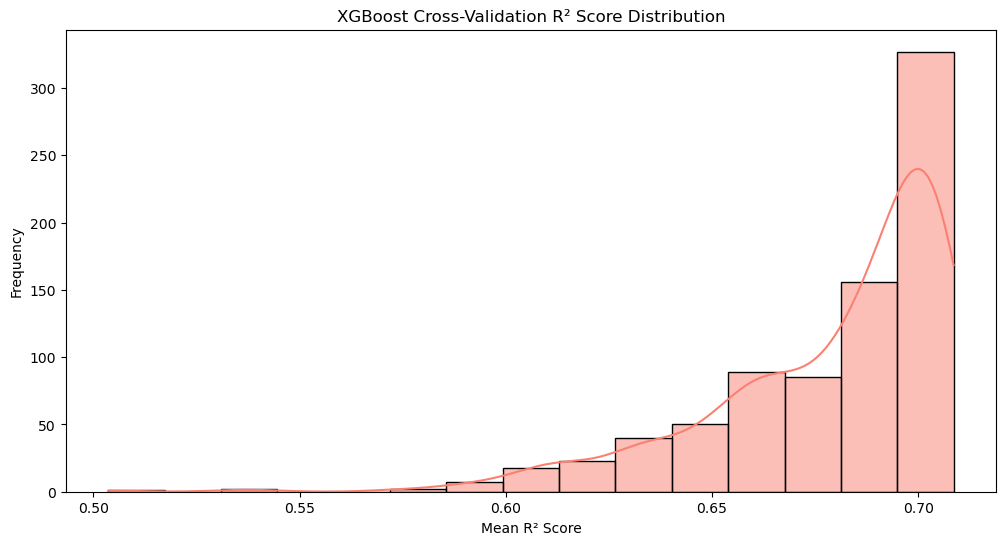

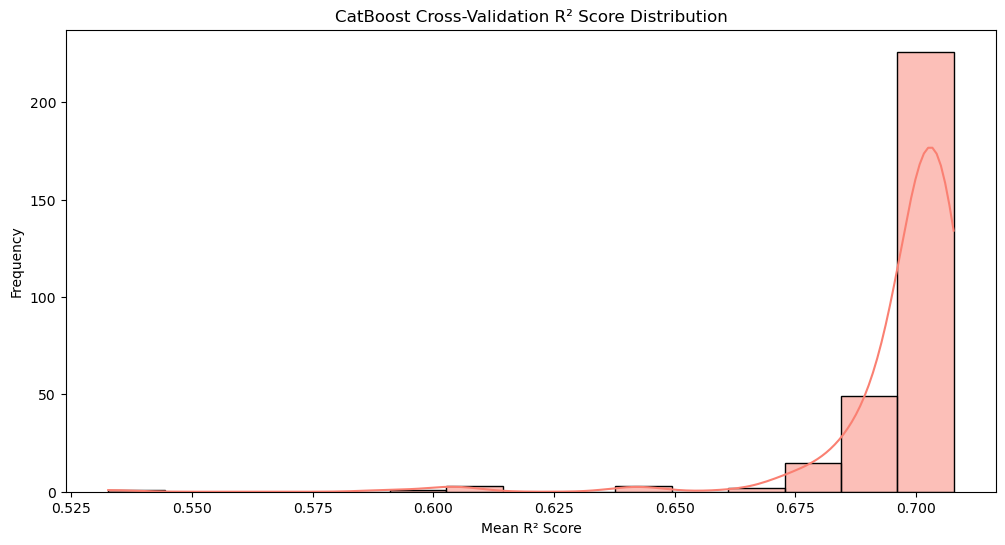


Summary of Cross-Validation Results:
      Model  Mean RMSE  Std RMSE  Mean R² Score  Std R² Score
0   XGBoost        NaN       NaN       0.679018      0.029290
1  CatBoost        NaN       NaN       0.697343      0.017582


In [282]:
# Assuming grid_search and catboost_grid_search have already been run
rf_cv_results = pd.DataFrame(random_search.cv_results_)
xgb_cv_results = pd.DataFrame(grid_search.cv_results_)
catboost_cv_results = pd.DataFrame(catboost_grid_search.cv_results_)

# Adding RMSE based on negative MSE scoring
xgb_cv_results['mean_test_rmse'] = np.sqrt(-xgb_cv_results['mean_test_score'])
catboost_cv_results['mean_test_rmse'] = np.sqrt(-catboost_cv_results['mean_test_score'])

# 1. Plotting Cross-Validation RMSE and R² Distributions
def plot_cv_results(cv_results, model_name):
    # Plot R² distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(cv_results['mean_test_score'], kde=True, color="salmon", bins=15)
    plt.title(f'{model_name} Cross-Validation R² Score Distribution')
    plt.xlabel('Mean R² Score')
    plt.ylabel('Frequency')
    plt.show()

plot_cv_results(xgb_cv_results, 'XGBoost')
plot_cv_results(catboost_cv_results, 'CatBoost')

# 2. Summary Table of Cross-Validation Results
summary_table = pd.DataFrame({
    'Model': ['XGBoost', 'CatBoost'],
    'Mean RMSE': [xgb_cv_results['mean_test_rmse'].mean(), catboost_cv_results['mean_test_rmse'].mean()],
    'Std RMSE': [xgb_cv_results['mean_test_rmse'].std(), catboost_cv_results['mean_test_rmse'].std()],
    'Mean R² Score': [xgb_cv_results['mean_test_score'].mean(), catboost_cv_results['mean_test_score'].mean()],
    'Std R² Score': [xgb_cv_results['mean_test_score'].std(), catboost_cv_results['mean_test_score'].std()]
})

print("\nSummary of Cross-Validation Results:")
print(summary_table)

In [283]:
rf_cv_results[rf_cv_results["mean_test_score"] == rf_cv_results["mean_test_score"].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,449.95872,3.12895,2.370783,0.099592,950,5,4,10,True,"{'n_estimators': 950, 'min_samples_split': 5, ...",0.736499,0.643593,0.699133,0.728616,0.722195,0.706007,0.033603,1


In [243]:
xgb_cv_results[xgb_cv_results["mean_test_score"] == xgb_cv_results["mean_test_score"].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,...,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_test_rmse
342,18.639386,0.940404,1.070446,0.217399,1.0,0.1,0.1,550,7,0.01,...,"{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alp...",0.735528,0.647153,0.701735,0.731732,0.726766,0.708583,0.032903,1,NaN


In [245]:
catboost_cv_results[catboost_cv_results["mean_test_score"] == catboost_cv_results["mean_test_score"].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_strength,param_n_estimators,param_learning_rate,param_l2_leaf_reg,param_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_test_rmse
184,144.406173,1.051061,0.094947,0.039041,0.2,650,0.01,3,10,"{'random_strength': 0.2, 'n_estimators': 650, ...",0.719846,0.668919,0.741097,0.701066,0.707834,0.707753,0.02371,1,NaN


In [284]:
import pandas as pd

# Collect cross-validation errors (MSE or R2 score)
def collect_cv_errors(grid_search, model_name):
    # Extract cross-validation results
    cv_results = grid_search.cv_results_
    
    # Use negative MSE for RMSE if `scoring='neg_mean_squared_error'`
    if 'neg_mean_squared_error' in cv_results:
        errors = -cv_results['mean_test_score']
    else:
        errors = cv_results['mean_test_score']
    
    # Calculate RMSE for each fold if MSE was used
    rmse_errors = (errors ** 0.5) if 'neg_mean_squared_error' in cv_results else errors
    
    return pd.DataFrame({
        'Model': model_name,
        'Fold': [f"Fold {i+1}" for i in range(len(rmse_errors))],
        'Validation Error (RMSE)': rmse_errors
    })

# Generate tables for each model
rf_errors = collect_cv_errors(random_search, "Random Forest")
xgb_errors = collect_cv_errors(grid_search, "XGBoost")
catboost_errors = collect_cv_errors(catboost_grid_search, "CatBoost")

# Concatenate all errors into a single DataFrame
error_table = pd.concat([rf_errors, xgb_errors, catboost_errors], axis=0, ignore_index=True)

# Display the table
print(error_table)

# Optional: Save the table as an image or CSV for including in a report
error_table.to_csv("cv_errors_comparative_table.csv", index=False)


              Model      Fold  Validation Error (RMSE)
0     Random Forest    Fold 1                 0.569040
1     Random Forest    Fold 2                 0.602959
2     Random Forest    Fold 3                 0.537367
3     Random Forest    Fold 4                 0.676611
4     Random Forest    Fold 5                 0.706001
...             ...       ...                      ...
1115       CatBoost  Fold 296                 0.695401
1116       CatBoost  Fold 297                 0.703061
1117       CatBoost  Fold 298                 0.687077
1118       CatBoost  Fold 299                 0.642427
1119       CatBoost  Fold 300                 0.701078

[1120 rows x 3 columns]


##### Learning curves

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import ShuffleSplit

# Création de la courbe d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(
    best_cat,
    X_xgb, y_xgb,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='r2',  # ou r2
    n_jobs=-1,
    shuffle=True
)

# Calcul des moyennes et écarts-types
train_scores_mean = np.mean(train_scores, axis=1)  # Utilisez - pour convertir en MSE positif
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Tracé de la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Erreur d\'entraînement', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.plot(train_sizes, val_scores_mean, label='Erreur de validation', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, color='orange', alpha=0.2)

plt.title('Courbes d\'apprentissage - XGBoost')
plt.xlabel('Taille de l\'ensemble d\'entraînement')
plt.ylabel('Erreur quadratique moyenne (MSE)')
plt.legend(loc='best')
plt.show()

##### **Analyse de l'importance des variables**

##### **1. Importance des Caractéristiques par Réduction de l'impureté**

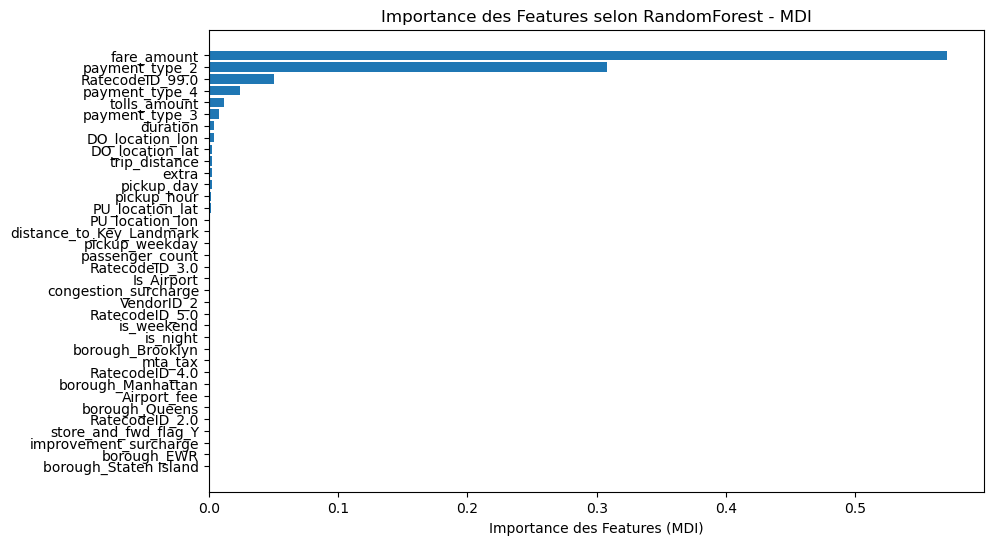

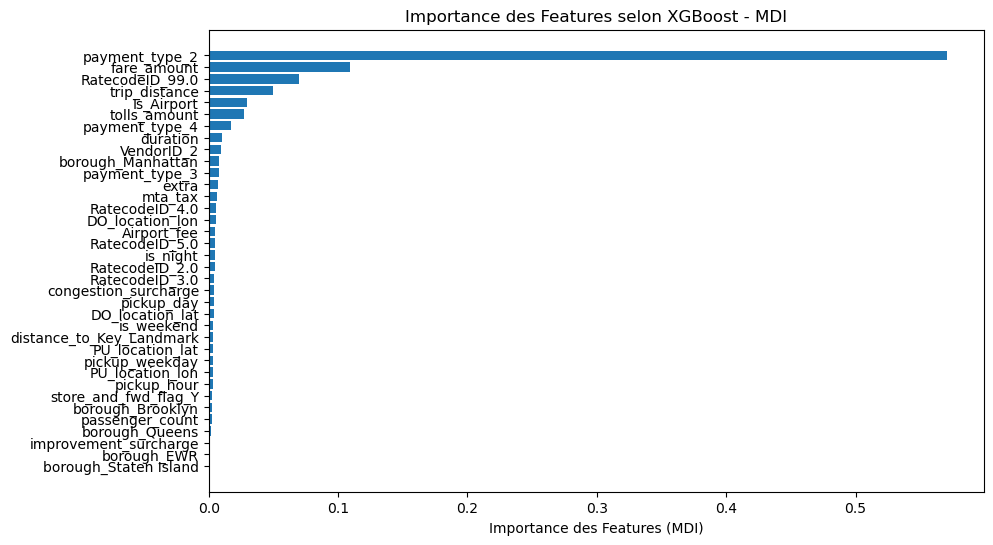

0:	learn: 3.6611285	total: 40ms	remaining: 25.9s
1:	learn: 3.6360712	total: 66.7ms	remaining: 21.6s
2:	learn: 3.6114345	total: 90.6ms	remaining: 19.5s
3:	learn: 3.5870751	total: 115ms	remaining: 18.5s
4:	learn: 3.5631557	total: 138ms	remaining: 17.8s
5:	learn: 3.5393563	total: 161ms	remaining: 17.3s
6:	learn: 3.5158864	total: 184ms	remaining: 16.9s
7:	learn: 3.4928483	total: 208ms	remaining: 16.7s
8:	learn: 3.4699964	total: 232ms	remaining: 16.5s
9:	learn: 3.4474438	total: 256ms	remaining: 16.4s
10:	learn: 3.4251983	total: 284ms	remaining: 16.5s
11:	learn: 3.4034864	total: 306ms	remaining: 16.3s
12:	learn: 3.3818597	total: 329ms	remaining: 16.1s
13:	learn: 3.3605040	total: 351ms	remaining: 16s
14:	learn: 3.3395062	total: 375ms	remaining: 15.9s
15:	learn: 3.3189056	total: 397ms	remaining: 15.7s
16:	learn: 3.2985096	total: 419ms	remaining: 15.6s
17:	learn: 3.2782484	total: 442ms	remaining: 15.5s
18:	learn: 3.2583191	total: 465ms	remaining: 15.4s
19:	learn: 3.2386183	total: 489ms	remainin

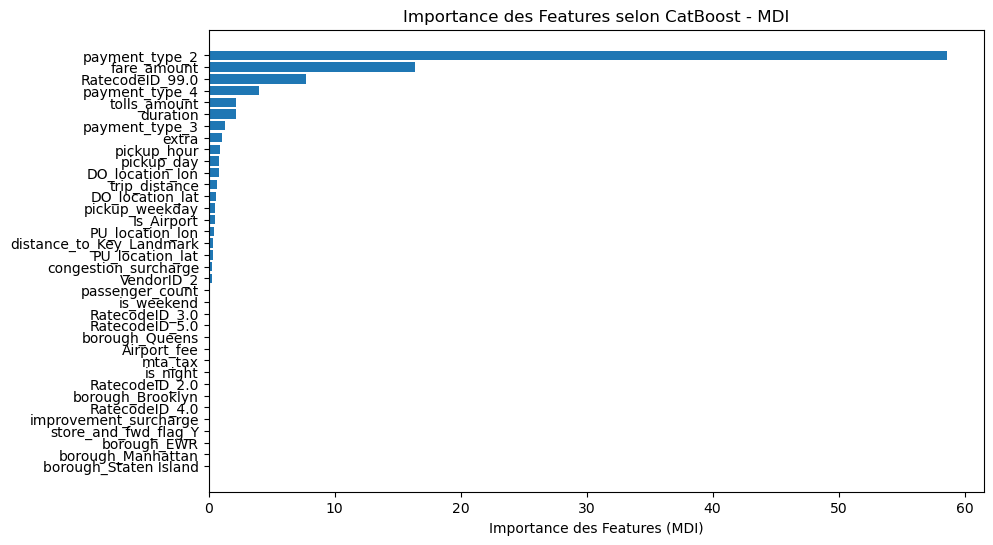

In [266]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

# Exemple de données d'entraînement et de validation
# X_train, X_val, y_train, y_val doivent être définis au préalable

# Modèles à tester
models = {
    'RandomForest': best_rf,
    'XGBoost': XGB_tunned_v2,
    'CatBoost': best_cat
}

# Dictionnaire pour stocker les importances de chaque modèle
feature_importances = {}

for model_name, model in models.items():
    # Entraînement du modèle
    model.fit(X_rf, y_rf)
    
    # Récupération de l'importance des features (MDI)
    if model_name == 'CatBoost':
        importances = model.get_feature_importance()
    else:
        importances = model.feature_importances_
    
    # Sauvegarder l'importance des features
    feature_importances[model_name] = importances

    # Visualisation
    sorted_idx = np.argsort(importances)
    plt.figure(figsize=(10, 6))
    plt.barh(X_rf.columns[sorted_idx], importances[sorted_idx])
    plt.xlabel("Importance des Features (MDI)")
    plt.title(f"Importance des Features selon {model_name} - MDI")
    plt.show()


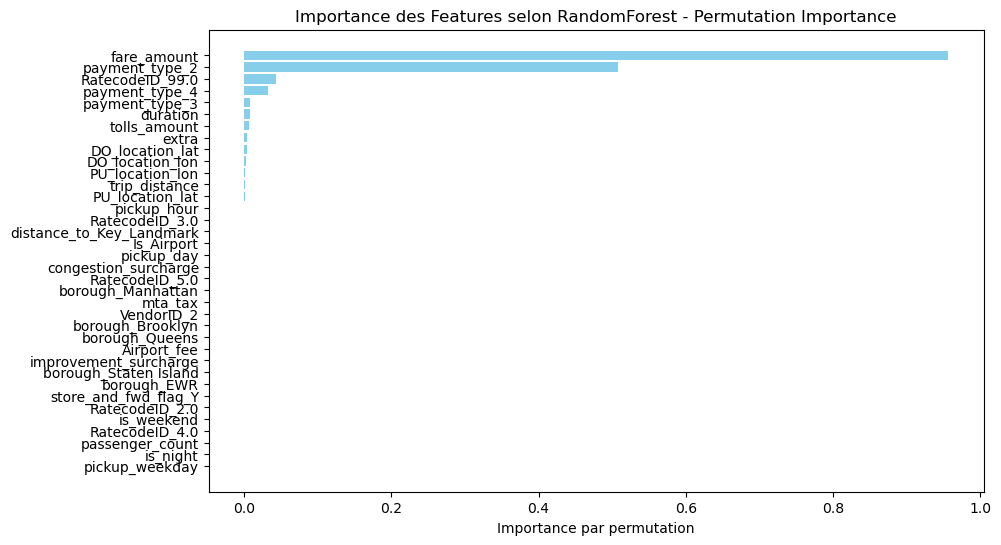

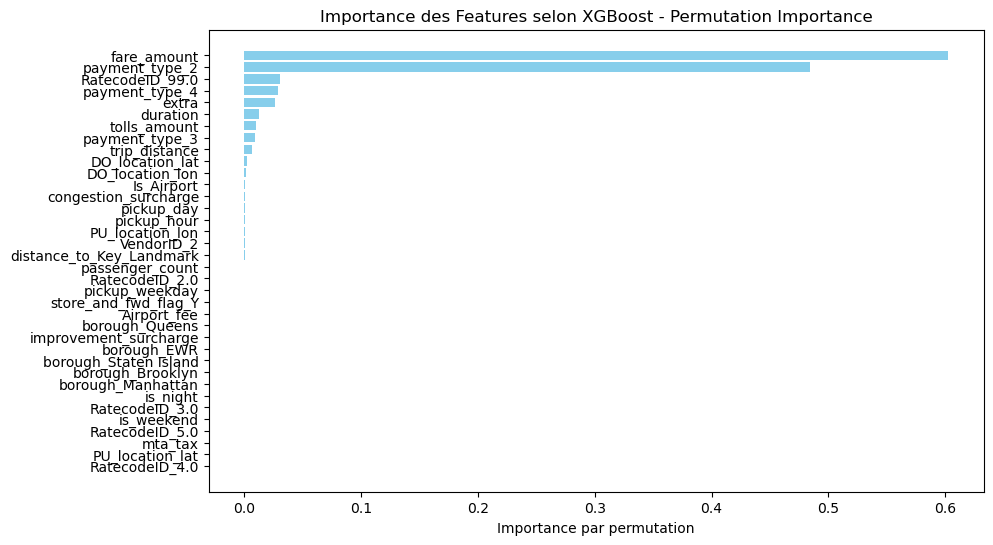

0:	learn: 3.6610731	total: 28.9ms	remaining: 18.7s
1:	learn: 3.6360400	total: 54.9ms	remaining: 17.8s
2:	learn: 3.6114171	total: 79.5ms	remaining: 17.1s
3:	learn: 3.5870741	total: 103ms	remaining: 16.7s
4:	learn: 3.5631959	total: 127ms	remaining: 16.4s
5:	learn: 3.5395927	total: 153ms	remaining: 16.4s
6:	learn: 3.5162101	total: 175ms	remaining: 16.1s
7:	learn: 3.4930910	total: 197ms	remaining: 15.8s
8:	learn: 3.4702774	total: 219ms	remaining: 15.6s
9:	learn: 3.4477833	total: 242ms	remaining: 15.5s
10:	learn: 3.4256014	total: 265ms	remaining: 15.4s
11:	learn: 3.4037232	total: 291ms	remaining: 15.5s
12:	learn: 3.3821060	total: 314ms	remaining: 15.4s
13:	learn: 3.3607934	total: 337ms	remaining: 15.3s
14:	learn: 3.3397606	total: 360ms	remaining: 15.2s
15:	learn: 3.3192033	total: 382ms	remaining: 15.1s
16:	learn: 3.2987414	total: 405ms	remaining: 15.1s
17:	learn: 3.2786371	total: 427ms	remaining: 15s
18:	learn: 3.2588500	total: 449ms	remaining: 14.9s
19:	learn: 3.2391798	total: 472ms	remain

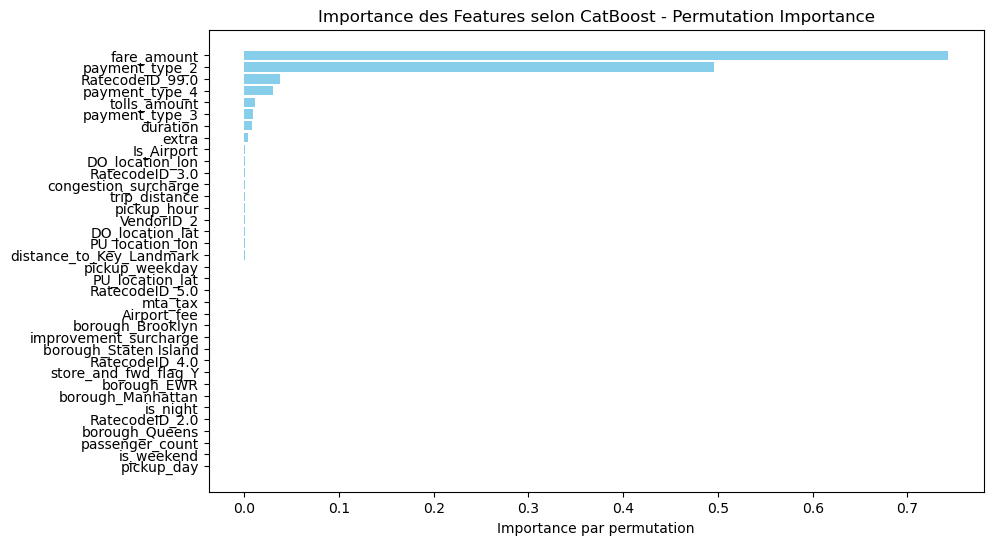

In [267]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

# Exemple de données d'entraînement et de validation
# X_train, X_val, y_train, y_val doivent être définis au préalable

# Modèles à tester
models = {
    'RandomForest': best_rf,
    'XGBoost': XGB_tunned_v2,
    'CatBoost': best_cat
}

# Dictionnaire pour stocker les importances de chaque modèle
permutation_importances = {}

for model_name, model in models.items():
    # Entraînement du modèle
    model.fit(X_train_rf, y_train_rf)
    
    # Calcul de l'importance par permutation
    result = permutation_importance(model, X_val_rf, y_val_rf, n_repeats=10, random_state=42, scoring='r2')
    importances = result.importances_mean
    
    # Sauvegarder les importances de permutation
    permutation_importances[model_name] = importances

    # Visualisation
    sorted_idx = np.argsort(importances)
    plt.figure(figsize=(10, 6))
    plt.barh(X_val_rf.columns[sorted_idx], importances[sorted_idx], color='skyblue')
    plt.xlabel("Importance par permutation")
    plt.title(f"Importance des Features selon {model_name} - Permutation Importance")
    plt.show()


#### **Stacking and submissions**

In [307]:
## Tree models
from joblib import dump, load

## Saving the final models

## Version 2

#dump(best_rf, 'Data/RandomForest_Tunned_v2.joblib')
#dump(best_xgb, 'Data/XGB_2_tunned_v2.joblib')
dump(best_cat, 'Data/CatBoost_tunned_2_v2.joblib')


['Data/CatBoost_tunned_2_v2.joblib']

In [308]:
#dump(grid_search, "xgb_grid_search_2_V2")
#dump(random_search, "RandomForest_GS_V2")
dump(catboost_grid_search, "Catboost_GS_2_V2")

['Catboost_GS_2_V2']

In [161]:
## Submission files for each model
#X_test_rf = rf_pipeline.transform(test_data)
X_test_xgb = xgb_pipeline.transform(test_data)
#X_test_cat = catboost_pipeline.transform(test_data)

In [162]:
## La colonne RateCode_ID_6.0 n'existe pas sur la base train

#X_test_rf = X_test_rf.drop(columns = ['RatecodeID_6.0'])
X_test_xgb = X_test_xgb.drop(columns = ['RatecodeID_6.0'])
#X_test_cat = X_test_cat.drop(columns = ['RatecodeID_6.0'])

In [309]:
# Loading models
#RandomForest_Tunned_v2 = load('Data/RandomForest_Tunned_2_V2')
#XGB_tunned_v2 = load('Data/XGB_tunned_v2.joblib')
CatBoost_tunned_v2 = load('Data/CatBoost_tunned_2_v2.joblib')

#X_test_rf = X_test_rf[RandomForest_Tunned_v2.feature_names_in_]

#y_test_rf = best_rf.predict(X_test_rf)
#y_test_xgb = XGB_tunned_2_v2.predict(X_test_xgb)
y_test_cat = CatBoost_tunned_v2.predict(X_test_cat)

In [88]:
len(y_test_cat)

2627163

In [305]:
y_test_rf

submission_RandomForest_Tunned_v2 = pd.DataFrame({"row_ID": range(len(y_test_rf)), "tip_amount": y_test_rf})
submission_RandomForest_Tunned_v2.to_parquet("submission_RandomForest_Tunned_2_v2.parquet", index = False)

In [164]:
y_test_xgb

submission_XGB_Tunned_2_v2 = pd.DataFrame({"row_ID": range(len(y_test_xgb)), "tip_amount": np.clip(y_test_xgb, 0, None)})
submission_XGB_Tunned_2_v2.to_parquet("submission_XGB_2_Tunned_v2_Cliped.parquet", index = False)

In [310]:
y_test_cat

submission_Cat_Tunned_v2 = pd.DataFrame({"row_ID": range(len(y_test_cat)), "tip_amount": np.clip(y_test_cat, 0, None)})
submission_Cat_Tunned_v2.to_parquet("submission_Cat_Tunned_2_v2.parquet", index = False)

In [ ]:
# Split training data for local validation
X_train, X_val, y_train, y_val = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

# Define base models
rf = best_rf
xgb = XGB_tunned_v2
cat = best_cat

# Define the meta-model
meta_model = Ridge()

# Stacking model
stacking_model = StackingRegressor(
    estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
    final_estimator=meta_model,
    cv=5
)

# Train the stacking model
stacking_model.fit(X_cat, y_cat)

In [315]:
dump(stacking_model, "stacking_model")

['stacking_model']

In [324]:
X_test_xgb[X_cat.columns].columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'distance_to_Key_Landmark', 'duration',
       'pickup_hour', 'pickup_day', 'pickup_weekday', 'is_night', 'is_weekend',
       'Is_Airport', 'VendorID_2', 'payment_type_2', 'payment_type_3',
       'payment_type_4', 'RatecodeID_2.0', 'RatecodeID_3.0', 'RatecodeID_4.0',
       'RatecodeID_5.0', 'RatecodeID_99.0', 'store_and_fwd_flag_Y',
       'borough_Brooklyn', 'borough_EWR', 'borough_Manhattan',
       'borough_Queens', 'borough_Staten Island'],
      dtype='object')

In [326]:
# Train on the full dataset and predict on the test set
#stacking_model.fit(X, y)
test_predictions = stacking_model.predict(X_test_xgb[X_cat.columns])

# Prepare submission file
submission = pd.DataFrame({
    'row_ID': range(len(test_predictions)),  # Replace with your actual Id column name
    'tip_amount': np.clip(test_predictions, 0, None) # Replace with your actual target column name
})
submission.to_parquet('Stacked_Linear_2_V2.parquet', index=False)

In [179]:
test_predictions

array([ 1.84860988,  2.61059765, -0.0451422 , ...,  2.17607006,
        3.06893477,  4.49045531])